# Import the necessary packages

In [9]:
import perceval as pcvl
import numpy as np

# Construct the circuit

### Parametrized Beamsplitter Cascade

The circuit that we will use as a reservoir is called the `"Parametrized Beamsplitter Cascade"` (PBC) circuit.

For a timeseries containing t data points the circuits constructs t layers consisting of overlapping beamsplitters. Each layer is parametrized by the corresponding datapoint. This constitutes the `interaction/learning` of the reservoir with the data.

Below you can see a schematic of such a layer:

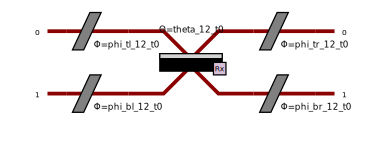

In [5]:
# We parametrize each connecting beamsplitter as general as possible, resulting in 4 SP and 1 BS: -> 5 parameters

def U_ij_t(i : int , j : int, t : int = 0):
    """Returns the unitary acting on mode i and j."""
    return (pcvl.Circuit(2, name=f"U_{i}{j}_t{t}")
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tl_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_bl_{i}{j}_t{t}")))
            .add(0, pcvl.BS(theta=pcvl.P(f'theta_{i}{j}_t{t}')))
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tr_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_br_{i}{j}_t{t}"))))

U_12 = U_ij_t(1, 2)
pcvl.pdisplay(U_12)

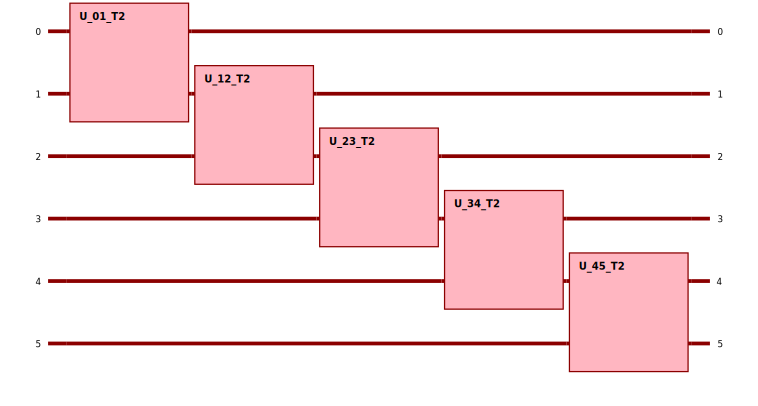

In [7]:
# Then for one layer we "cascade" the BS and connect each mode: -> per layer (m-1)*5 parameters

def full_layer(n : int, t : int = 0, _overlapping : bool = False):
    layer = pcvl.Circuit(n)
    if _overlapping:
        for i in range(n-1):
            layer = layer.add(i, U_ij_t(i, (i+1), t))
    else:
        if n % 2 != 0:
            print("WARNING: The number is not even and _overlapping is False => the last mode will be ignored.")
        for i in range((n)//2):
            layer = layer.add(2*i, U_ij_t(i, i+1, t))
    return layer

layer = full_layer(6, 2, True)
pcvl.pdisplay(layer)

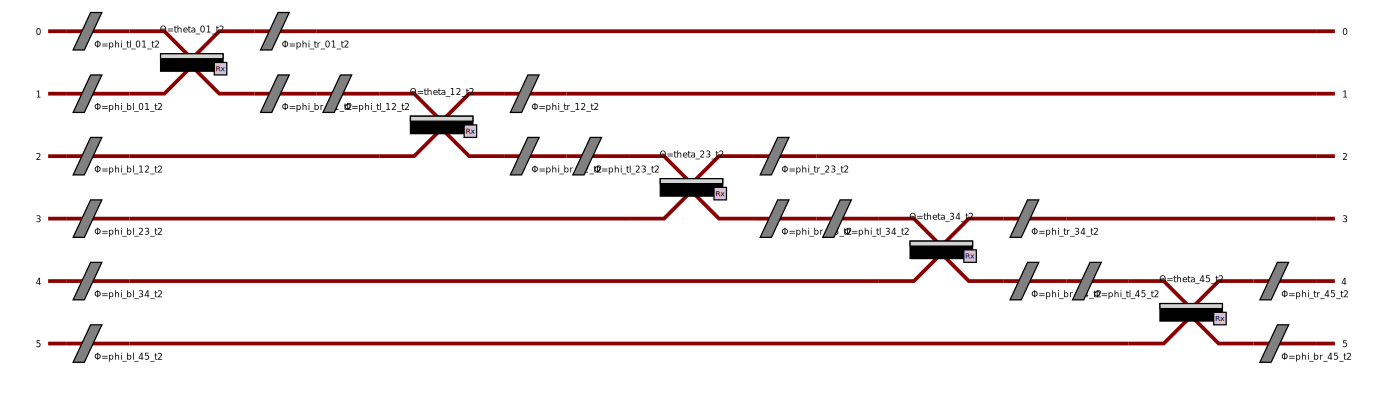

In [8]:
# Unpacked the circuit looks like this:

def full_layer(n : int, t : int = 0, _overlapping : bool = False):
    layer = pcvl.Circuit(n)
    
    # Function to add unitary gates directly to the layer
    def add_U_ij_t(layer, i, j, t):
        layer.add(i, pcvl.PS(phi=pcvl.P(f"phi_tl_{i}{j}_t{t}")))
        layer.add(j, pcvl.PS(phi=pcvl.P(f"phi_bl_{i}{j}_t{t}")))
        layer.add(i, pcvl.BS(theta=pcvl.P(f'theta_{i}{j}_t{t}')))
        layer.add(i, pcvl.PS(phi=pcvl.P(f"phi_tr_{i}{j}_t{t}")))
        layer.add(j, pcvl.PS(phi=pcvl.P(f"phi_br_{i}{j}_t{t}")))

    if _overlapping:
        for i in range(n-1):
            add_U_ij_t(layer, i, i+1, t)
    else:
        if n % 2 != 0:
            print("WARNING: The number is not even and _overlapping is False => the last mode will be ignored.")
        for i in range(n // 2):
            add_U_ij_t(layer, 2*i, 2*i+1, t)
    
    return layer

layer = full_layer(6, 2, True)
pcvl.pdisplay(layer)

# Parametrize the circuit

In [16]:
# To show how the parametrization work we will generate a random data matrix of the correct shape:

def generate_rndm_param_matrix(circuit, num_layers):
        """Generates a random parameter matrix of size (t, num_parameters)."""

        num_parameters = len(circuit.get_parameters())
        # Random dataset of angles
        return np.random.rand(num_layers, num_parameters//num_layers)*2*np.pi

# We can now generate a random data matrix for the circuit:
data = generate_rndm_param_matrix(circuit=layer, num_layers=1)
print(f"data.shape: {data.shape}")

data.shape: (1, 25)


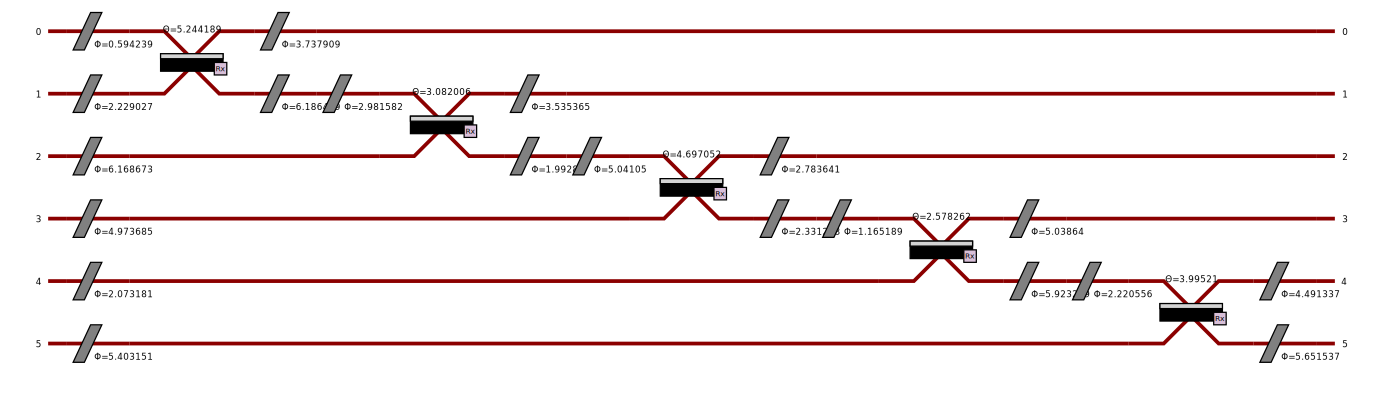

In [19]:
# Now we can parametrize our layer with the data matrix:

def set_circuit_parameters(circuit, parameter_matrix):
    # Flatten the parameter matrix to match the list of parameters
    flattened_params = parameter_matrix.flatten() # [[1,2], [3,4]] -> [1,2,3,4]
    # Get the parameters from the circuit
    params = circuit.get_parameters()

    # Assert that the lengths match
    assert len(params) == len(flattened_params), f"The number of parameters {len(params)} in the circuit does not match the size of the matrix {len(flattened_params)}."

    # Set the values of the parameters
    for param, value in zip(params, flattened_params):
        param.set_value(value)

set_circuit_parameters(layer, data)

# We can now display the circuit with the parameters set:
pcvl.pdisplay(layer)


# Process

So now we have created a reservoir circuit using our PBC circuit, now we need to get data and parametrize the circuit and process the data.